# Great Energy Predictor - Feature Selection
#### Hosted by: ASHRAE
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction

### Dependencies

In [1]:
%matplotlib inline

import src.utils as udf

import gc
import datetime
import holidays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.categorical_encoders import RareLabelCategoricalEncoder as RareEncoder, \
                                                MeanCategoricalEncoder as MeanEncoder, \
                                                OrdinalCategoricalEncoder as OrdinalEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, f_regression, RFE, SelectFromModel, SelectKBest, SelectPercentile
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# import os

# Pandas on dask
# os.environ['MODIN_ENGINE'] = 'dask'
# import modin.pandas as dd 

# Pandas on ray
# os.environ['MODIN_ENGINE'] = 'ray'
# import ray
# ray.init()
# import modin.pandas as ray

In [2]:
# Plot settings
sns.set(rc={'figure.figsize': (16, 4),
            'font.size': 16})

### Load data

In [3]:
path = '../data/from_pre/'

In [5]:
train = pd.read_pickle(f'{path}train.pkl')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 20 columns):
site_id               uint8
building_id           uint16
meter                 uint8
meter_type            category
timestamp             datetime64[ns]
meter_reading         float32
air_temperature       float32
dew_temperature       float32
sea_level_pressure    float32
wind_direction        uint16
wind_speed            float32
primary_use           category
square_feet           uint32
year_built            int64
missing_year          int64
dayofyear             uint16
month                 uint8
day                   uint8
hour                  uint8
dayofweek             uint8
dtypes: category(2), datetime64[ns](1), float32(5), int64(2), uint16(3), uint32(1), uint8(6)
memory usage: 1.2 GB


In [6]:
train = udf.reduce_mem_usage(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 20 columns):
site_id               uint8
building_id           uint16
meter                 uint8
meter_type            category
timestamp             datetime64[ns]
meter_reading         float32
air_temperature       float32
dew_temperature       float32
sea_level_pressure    float32
wind_direction        uint16
wind_speed            float32
primary_use           category
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
month                 uint8
day                   uint8
hour                  uint8
dayofweek             uint8
dtypes: category(2), datetime64[ns](1), float32(5), uint16(4), uint32(1), uint8(7)
memory usage: 992.9 MB


In [7]:
del path
gc.collect()

44

### Feature engineering

In [8]:
# Extract x and y components from wind_direction
train = udf.deg_to_components(train, 'wind_direction')

# Drop wind_direction
train.drop('wind_direction', axis=1, inplace=True)

train.head()

,site_id,building_id,meter,meter_type,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_speed,...,square_feet,year_built,missing_year,dayofyear,month,day,hour,dayofweek,wind_direction_x,wind_direction_y
0,0,46,0,electricity,2016-01-01,15.604556,19.4,19.4,1019.400024,0.0,...,9045,2016,0,1,1,1,0,4,0.0,0.000000
1,0,74,0,electricity,2016-01-01,12.603682,19.4,19.4,1019.400024,0.0,...,387638,1997,0,1,1,1,0,4,0.0,0.000000
2,0,93,0,electricity,2016-01-01,15.364478,19.4,19.4,1019.400024,0.0,...,33370,1982,0,1,1,1,0,4,0.0,0.000000
3,1,105,0,electricity,2016-01-01,23.303600,3.8,2.4,1020.900024,3.1,...,50623,1960,1,1,1,1,0,4,-0.5,-0.866025
4,1,106,0,electricity,2016-01-01,0.374600,3.8,2.4,1020.900024,3.1,...,5374,1960,1,1,1,1,0,4,-0.5,-0.866025


In [9]:
# Add feature for relative humidity
train['rel_humidity'] = udf.calc_rel_humidity(train.air_temperature, train.dew_temperature)
train.describe()

,site_id,building_id,meter,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_speed,square_feet,year_built,missing_year,dayofyear,month,day,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity
count,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07
mean,8.013800e+00,8.037511e+02,5.951358e-01,3.413591e+02,1.603343e+01,7.850799e+00,1.016059e+03,3.380148e+00,1.062238e+05,1.967027e+03,5.999500e-01,1.877835e+02,6.652901e+00,1.579648e+01,1.152170e+01,3.002913e+00,-5.101069e-02,-4.493903e-02,6.401447e+01
std,5.051005e+00,4.205652e+02,8.913411e-01,8.350884e+02,1.086172e+01,1.013072e+01,7.257745e+00,2.272173e+00,1.147711e+05,1.992809e+01,4.899082e-01,1.047606e+02,3.419557e+00,8.818303e+00,6.911360e+00,1.995784e+00,6.678199e-01,6.535204e-01,2.288399e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-04,-2.890000e+01,-3.500000e+01,9.682000e+02,0.000000e+00,2.830000e+02,1.900000e+03,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,3.751658e+00
25%,3.000000e+00,4.130000e+02,0.000000e+00,2.853000e+01,8.900000e+00,6.000000e-01,1.011600e+03,2.100000e+00,3.130000e+04,1.961000e+03,0.000000e+00,1.000000e+02,4.000000e+00,8.000000e+00,6.000000e+00,1.000000e+00,-7.660444e-01,-6.427876e-01,4.760014e+01
50%,9.000000e+00,8.930000e+02,0.000000e+00,9.136780e+01,1.670000e+01,8.900000e+00,1.016100e+03,3.100000e+00,7.180600e+04,1.964000e+03,1.000000e+00,1.900000e+02,7.000000e+00,1.600000e+01,1.200000e+01,3.000000e+00,0.000000e+00,0.000000e+00,6.723316e+01
75%,1.300000e+01,1.180000e+03,1.000000e+00,2.793400e+02,2.440000e+01,1.610000e+01,1.020507e+03,4.600000e+00,1.389770e+05,1.971000e+03,1.000000e+00,2.780000e+02,1.000000e+01,2.300000e+01,1.800000e+01,5.000000e+00,5.000000e-01,5.000000e-01,8.362017e+01
max,1.500000e+01,1.448000e+03,3.000000e+00,1.165430e+04,4.720000e+01,2.610000e+01,1.045500e+03,1.900000e+01,8.750000e+05,2.017000e+03,1.000000e+00,3.660000e+02,1.200000e+01,3.100000e+01,2.300000e+01,6.000000e+00,1.000000e+00,1.000000e+00,1.192694e+02


In [10]:
# Add weekend feature
train['is_weekend'] = train.dayofweek.apply(lambda d: int(d in [5, 6]))
train.tail()

,site_id,building_id,meter,meter_type,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_speed,...,missing_year,dayofyear,month,day,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity,is_weekend
18264890,15,1443,0,electricity,2016-12-31 23:00:00,64.949997,1.7,-5.6,1008.5,8.8,...,0,366,12,31,23,5,-1.0,1.224647e-16,58.261791,1
18264891,15,1444,0,electricity,2016-12-31 23:00:00,8.750000,1.7,-5.6,1008.5,8.8,...,0,366,12,31,23,5,-1.0,1.224647e-16,58.261791,1
18264892,15,1445,0,electricity,2016-12-31 23:00:00,4.825000,1.7,-5.6,1008.5,8.8,...,1,366,12,31,23,5,-1.0,1.224647e-16,58.261791,1
18264893,15,1447,0,electricity,2016-12-31 23:00:00,159.574997,1.7,-5.6,1008.5,8.8,...,0,366,12,31,23,5,-1.0,1.224647e-16,58.261791,1
18264894,15,1448,0,electricity,2016-12-31 23:00:00,2.850000,1.7,-5.6,1008.5,8.8,...,0,366,12,31,23,5,-1.0,1.224647e-16,58.261791,1


In [11]:
# Add country feature
countries = {0: 'US', 1: 'UK', 2: 'US', 3: 'US', 4: 'US', 5: 'UK', 6: 'US', 7: 'CA', 8: 'US', 9: 'US', 10: 'US', 11: 'CA', 12: 'IE', 13: 'US', 14: 'US', 15: 'US'}
train['country'] = train.site_id.map(countries)
train.head()

,site_id,building_id,meter,meter_type,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_speed,...,dayofyear,month,day,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country
0,0,46,0,electricity,2016-01-01,15.604556,19.4,19.4,1019.400024,0.0,...,1,1,1,0,4,0.0,0.000000,100.000000,0,US
1,0,74,0,electricity,2016-01-01,12.603682,19.4,19.4,1019.400024,0.0,...,1,1,1,0,4,0.0,0.000000,100.000000,0,US
2,0,93,0,electricity,2016-01-01,15.364478,19.4,19.4,1019.400024,0.0,...,1,1,1,0,4,0.0,0.000000,100.000000,0,US
3,1,105,0,electricity,2016-01-01,23.303600,3.8,2.4,1020.900024,3.1,...,1,1,1,0,4,-0.5,-0.866025,90.549408,0,UK
4,1,106,0,electricity,2016-01-01,0.374600,3.8,2.4,1020.900024,3.1,...,1,1,1,0,4,-0.5,-0.866025,90.549408,0,UK


In [12]:
# Holidays
US_holidays = holidays.UnitedStates()     # sites 0, 2, 3, 4, 6, 8, 9, 10, 13, 14, 15 
CA_holidays = holidays.Canada()           # sites 7, 11
UK_holidays = holidays.UnitedKingdom()    # sites 1, 5
IE_holidays = holidays.Ireland()          # site 12

In [13]:
# Split countries into separate dataframes
train_US = train[train.country == 'US'].copy()
train_CA = train[train.country == 'CA'].copy()
train_UK = train[train.country == 'UK'].copy()
train_IE = train[train.country == 'IE'].copy()

In [14]:
# Add a holiday indicator feature
train_US['is_holiday'] = train_US.timestamp.map(lambda d: int(d in US_holidays))
train_CA['is_holiday'] = train_CA.timestamp.map(lambda d: int(d in CA_holidays))
train_UK['is_holiday'] = train_UK.timestamp.map(lambda d: int(d in UK_holidays))
train_IE['is_holiday'] = train_IE.timestamp.map(lambda d: int(d in IE_holidays))

In [15]:
# Concatenate the dataframes and sort the values
train = pd.concat([train_US, train_CA, train_UK, train_IE])
train.sort_values(['timestamp', 'building_id', 'meter'], inplace=True)
train.head()

,site_id,building_id,meter,meter_type,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_speed,...,month,day,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0,46,0,electricity,2016-01-01,15.604556,19.4,19.4,1019.400024,0.0,...,1,1,0,4,0.0,0.000000,100.000000,0,US,1
1,0,74,0,electricity,2016-01-01,12.603682,19.4,19.4,1019.400024,0.0,...,1,1,0,4,0.0,0.000000,100.000000,0,US,1
2,0,93,0,electricity,2016-01-01,15.364478,19.4,19.4,1019.400024,0.0,...,1,1,0,4,0.0,0.000000,100.000000,0,US,1
3,1,105,0,electricity,2016-01-01,23.303600,3.8,2.4,1020.900024,3.1,...,1,1,0,4,-0.5,-0.866025,90.549408,0,UK,1
4,1,106,0,electricity,2016-01-01,0.374600,3.8,2.4,1020.900024,3.1,...,1,1,0,4,-0.5,-0.866025,90.549408,0,UK,1


In [16]:
del countries, US_holidays, CA_holidays, UK_holidays, IE_holidays, train_US, train_CA, train_UK, train_IE
gc.collect()

22

### Split train set by meter type

In [17]:
# Number of observations in each group of sites and meters
train.groupby(['site_id', 'meter']).building_id.count().reset_index()

,site_id,meter,building_id
0,0,0,561983
1,0,1,152603
2,1,0,447978
3,1,3,66183
4,2,0,1174568
5,2,1,800001
6,2,3,302936
7,3,0,2366997
8,4,0,742867
9,5,0,773753


In [18]:
# Separate meter types into different dataframes
meter = ['electricity', 'chilledwater', 'steam', 'hotwater']
train_df = []
for m in range(4):
    train_df.append(train[train.meter == m].drop(['meter', 'meter_type'], axis=1))
    print(f'{meter[m]} meter: {train_df[m].shape}')

electricity meter: (11530268, 23)
chilledwater meter: (3518870, 23)
steam meter: (2296049, 23)
hotwater meter: (919708, 23)


In [19]:
train_df[0].head()

,site_id,building_id,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,...,month,day,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0,46,2016-01-01,15.604556,19.4,19.4,1019.400024,0.0,Retail,9045,...,1,1,0,4,0.0,0.000000,100.000000,0,US,1
1,0,74,2016-01-01,12.603682,19.4,19.4,1019.400024,0.0,Parking,387638,...,1,1,0,4,0.0,0.000000,100.000000,0,US,1
2,0,93,2016-01-01,15.364478,19.4,19.4,1019.400024,0.0,Office,33370,...,1,1,0,4,0.0,0.000000,100.000000,0,US,1
3,1,105,2016-01-01,23.303600,3.8,2.4,1020.900024,3.1,Education,50623,...,1,1,0,4,-0.5,-0.866025,90.549408,0,UK,1
4,1,106,2016-01-01,0.374600,3.8,2.4,1020.900024,3.1,Education,5374,...,1,1,0,4,-0.5,-0.866025,90.549408,0,UK,1


In [20]:
# Save train set
path = '../data/from_fts/'
train.to_pickle(f'{path}train.pkl')
train = pd.read_pickle(f'{path}train.pkl')
train.head()

,site_id,building_id,meter,meter_type,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_speed,...,month,day,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0,46,0,electricity,2016-01-01,15.604556,19.4,19.4,1019.400024,0.0,...,1,1,0,4,0.0,0.000000,100.000000,0,US,1
1,0,74,0,electricity,2016-01-01,12.603682,19.4,19.4,1019.400024,0.0,...,1,1,0,4,0.0,0.000000,100.000000,0,US,1
2,0,93,0,electricity,2016-01-01,15.364478,19.4,19.4,1019.400024,0.0,...,1,1,0,4,0.0,0.000000,100.000000,0,US,1
3,1,105,0,electricity,2016-01-01,23.303600,3.8,2.4,1020.900024,3.1,...,1,1,0,4,-0.5,-0.866025,90.549408,0,UK,1
4,1,106,0,electricity,2016-01-01,0.374600,3.8,2.4,1020.900024,3.1,...,1,1,0,4,-0.5,-0.866025,90.549408,0,UK,1


In [21]:
del train, meter, m
gc.collect()

66

### Train/test split - electricity

In [22]:
# Split data and target
Xe = train_df[0].drop('meter_reading', axis=1).copy()
ye = train_df[0][['meter_reading']].copy()
print(Xe.shape)
print(ye.shape)

(11530268, 22)
(11530268, 1)


In [23]:
# Train/val/test split
Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe, ye, test_size=0.2, random_state=42)
Xe_train, Xe_val, ye_train, ye_val = train_test_split(Xe_train, ye_train, test_size=0.2, random_state=42)

print('Train set:', Xe_train.shape, ye_train.shape)
print('Validation set:', Xe_val.shape, ye_val.shape)
print('Test set:', Xe_test.shape, ye_test.shape)

Train set: (7379371, 22) (7379371, 1)
Validation set: (1844843, 22) (1844843, 1)
Test set: (2306054, 22) (2306054, 1)


In [24]:
Xe_train.head()

,site_id,building_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,...,month,day,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
4864049,10,1027,2016-04-15 12:00:00,8.9,-1.7,1012.799988,6.2,Lodging/residential,35465,1968,...,4,15,12,4,0.866025,-0.500000,47.289181,0,US,0
5053650,14,1229,2016-04-19 08:00:00,20.0,3.9,1014.900024,4.6,Office,27646,1970,...,4,19,8,1,0.984808,-0.173648,34.537556,0,US,0
4618276,3,408,2016-04-10 13:00:00,8.3,-6.1,1028.400024,4.6,Entertainment/public assembly,16098,1929,...,4,10,13,6,-0.984808,0.173648,35.371906,1,US,0
12023549,3,517,2016-09-02 05:00:00,20.0,13.3,1017.799988,6.2,Lodging/residential,2210,1961,...,9,2,5,4,0.984808,0.173648,65.323219,0,US,0
16250821,3,455,2016-11-22 21:00:00,5.6,-6.1,1026.900024,5.1,Healthcare,29192,2014,...,11,22,21,1,0.766044,-0.642788,42.580299,0,US,0


In [25]:
del Xe, ye
gc.collect()

22

### Feature engineering

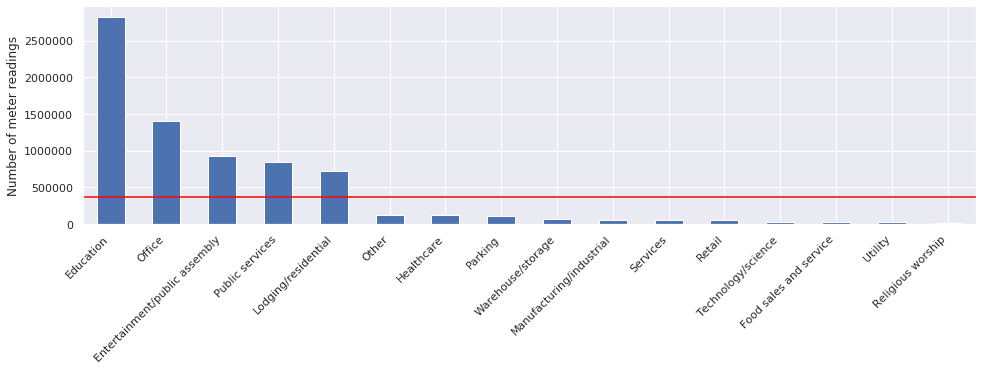

In [26]:
# Inspect primary_use categories
udf.find_rare_cats(Xe_train, 'primary_use')
plt.ylabel('Number of meter readings');

In [27]:
# Cast primary_use as string type
Xe_train.primary_use = Xe_train.primary_use.astype(str)

# Find common (not rare) categories
rarenc = RareEncoder(tol=0.05, variables=['primary_use'])
rarenc.fit(Xe_train)
rarenc.encoder_dict_

{'primary_use': Index(['Education', 'Office', 'Entertainment/public assembly',
        'Public services', 'Lodging/residential'],
       dtype='object')}

In [28]:
# Group rare categories together in both train and validation sets
Xe_train = rarenc.transform(Xe_train)
Xe_val = rarenc.transform(Xe_val)

Xe_train.primary_use.value_counts()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


Education                        2826588
Office                           1403395
Entertainment/public assembly     931691
Public services                   840754
Lodging/residential               724852
Rare                              652091
Name: primary_use, dtype: int64

In [29]:
# Check the mean target of each primary_use and country category
meanenc = MeanEncoder(variables=['primary_use', 'country'])
meanenc.fit(Xe_train, ye_train)
meanenc.encoder_dict_

{'primary_use': {'Education': 239.61399841308594,
  'Entertainment/public assembly': 112.89617919921875,
  'Lodging/residential': 91.39266204833984,
  'Office': 154.91171264648438,
  'Public services': 99.10198211669922,
  'Rare': 110.2436294555664},
 'country': {'CA': 1617.39453125,
  'IE': 99.73006439208984,
  'UK': 79.67478942871094,
  'US': 158.36424255371094}}

In [30]:
# Encode primary_use and country using the target mean in both train and validation sets
Xe_train = meanenc.transform(Xe_train)
Xe_val = meanenc.transform(Xe_val)

Xe_train.head()

,site_id,building_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,...,month,day,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
4864049,10,1027,2016-04-15 12:00:00,8.9,-1.7,1012.799988,6.2,91.392662,35465,1968,...,4,15,12,4,0.866025,-0.500000,47.289181,0,158.364243,0
5053650,14,1229,2016-04-19 08:00:00,20.0,3.9,1014.900024,4.6,154.911713,27646,1970,...,4,19,8,1,0.984808,-0.173648,34.537556,0,158.364243,0
4618276,3,408,2016-04-10 13:00:00,8.3,-6.1,1028.400024,4.6,112.896179,16098,1929,...,4,10,13,6,-0.984808,0.173648,35.371906,1,158.364243,0
12023549,3,517,2016-09-02 05:00:00,20.0,13.3,1017.799988,6.2,91.392662,2210,1961,...,9,2,5,4,0.984808,0.173648,65.323219,0,158.364243,0
16250821,3,455,2016-11-22 21:00:00,5.6,-6.1,1026.900024,5.1,110.243629,29192,2014,...,11,22,21,1,0.766044,-0.642788,42.580299,0,158.364243,0


In [31]:
del rarenc, meanenc
gc.collect()

3980

### Feature elimination

In [32]:
# Duplicated features
udf.duplicated_feats(Xe_train)

[]

In [33]:
# Constant and quasi-constant features
udf.constant_feats(Xe_train)

,variance,constant,quasiconstant
site_id,2.382449e+01,False,False
building_id,1.647319e+05,False,False
air_temperature,1.099655e+02,False,False
dew_temperature,9.773034e+01,False,False
sea_level_pressure,5.487634e+01,False,False
wind_speed,5.390166e+00,False,False
primary_use,3.786238e+03,False,False
square_feet,1.252709e+10,False,False
year_built,4.586236e+02,False,False
missing_year,2.476069e-01,False,False


In [34]:
# Feature correlation
Xe_train.corr()

,site_id,building_id,air_temperature,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,...,month,day,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
site_id,1.000000,0.975700,-0.267703,-0.145787,0.012763,-0.001656,-0.048963,0.093897,-0.040203,0.423460,...,-0.029724,-0.002942,-0.000487,-0.000205,-0.014085,-0.024710,0.140830,-0.000458,0.055820,-0.005704
building_id,0.975700,1.000000,-0.283272,-0.126310,0.033750,0.000621,-0.040202,0.085483,-0.083875,0.395296,...,-0.036685,-0.003615,-0.000419,-0.000180,-0.007583,-0.039721,0.185825,-0.000597,0.061003,-0.005219
air_temperature,-0.267703,-0.283272,1.000000,0.758730,-0.254134,-0.080891,-0.025527,-0.005184,0.091660,-0.030466,...,0.186530,0.023958,0.137881,-0.007856,-0.151271,0.099520,-0.312377,-0.011455,-0.053056,-0.061838
dew_temperature,-0.145787,-0.126310,0.758730,1.000000,-0.183033,-0.130991,-0.030101,-0.025170,0.040144,-0.026532,...,0.257086,0.023113,-0.004456,-0.007400,-0.161567,0.153871,0.348775,-0.012943,-0.065509,-0.047507
sea_level_pressure,0.012763,0.033750,-0.254134,-0.183033,1.000000,-0.213124,-0.032936,-0.017929,-0.026818,0.013246,...,0.154690,0.029908,-0.027203,-0.010051,0.122549,0.130213,0.037044,-0.004576,-0.009263,0.076642
wind_speed,-0.001656,0.000621,-0.080891,-0.130991,-0.213124,1.000000,0.006003,-0.039764,-0.032661,-0.068412,...,-0.076336,-0.012106,0.125825,0.010933,0.036302,-0.196985,-0.108122,0.014134,-0.033072,-0.002460
primary_use,-0.048963,-0.040202,-0.025527,-0.030101,-0.032936,0.006003,1.000000,0.089559,-0.124012,-0.172689,...,-0.006550,-0.001220,0.000067,0.000877,-0.005468,-0.036302,0.009684,0.000257,0.109245,-0.000137
square_feet,0.093897,0.085483,-0.005184,-0.025170,-0.017929,-0.039764,0.089559,1.000000,0.094808,-0.043962,...,-0.000146,-0.000644,0.000193,-0.000076,-0.012739,0.011529,-0.032950,-0.000460,0.199671,-0.003435
year_built,-0.040203,-0.083875,0.091660,0.040144,-0.026818,-0.032661,-0.124012,0.094808,1.000000,-0.003819,...,0.042618,0.003681,0.000152,-0.000212,0.002499,0.052960,-0.063137,0.000177,0.002966,0.000841
missing_year,0.423460,0.395296,-0.030466,-0.026532,0.013246,-0.068412,-0.172689,-0.043962,-0.003819,1.000000,...,-0.048894,-0.001496,0.000025,-0.000382,-0.039487,0.042455,-0.037563,-0.000190,0.004593,-0.009263


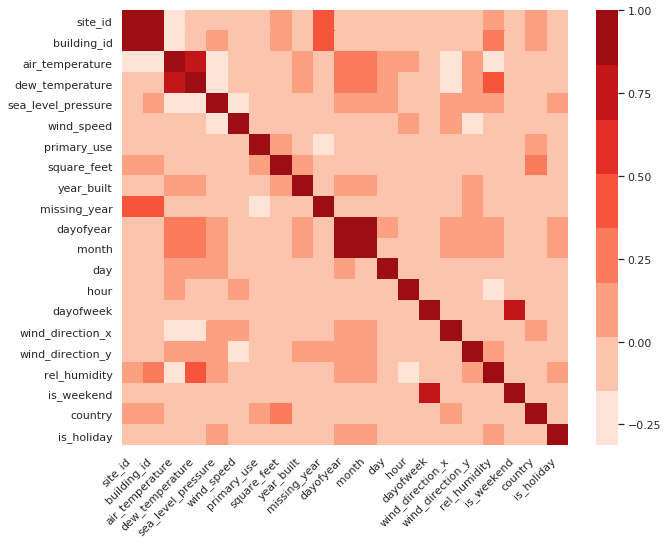

In [35]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(Xe_train.corr(), cmap=sns.color_palette('Reds', 8))
plt.xticks(rotation=45, ha='right');

In [36]:
# Correlated features
udf.correlated_feats(Xe_train.corr(), threshold=0.5)

[('site_id', 'building_id', 0.975700223861805),
 ('air_temperature', 'dew_temperature', 0.7587299790065459),
 ('dayofyear', 'month', 0.9964748602636748),
 ('dayofweek', 'is_weekend', 0.7894595053246916)]

In [37]:
# Drop timestamp from both train and validation sets
Xe_train.drop('timestamp', axis=1, inplace=True)
Xe_val.drop('timestamp', axis=1, inplace=True)

Xe_train.head()

,site_id,building_id,air_temperature,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,...,month,day,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
4864049,10,1027,8.9,-1.7,1012.799988,6.2,91.392662,35465,1968,1,...,4,15,12,4,0.866025,-0.500000,47.289181,0,158.364243,0
5053650,14,1229,20.0,3.9,1014.900024,4.6,154.911713,27646,1970,1,...,4,19,8,1,0.984808,-0.173648,34.537556,0,158.364243,0
4618276,3,408,8.3,-6.1,1028.400024,4.6,112.896179,16098,1929,0,...,4,10,13,6,-0.984808,0.173648,35.371906,1,158.364243,0
12023549,3,517,20.0,13.3,1017.799988,6.2,91.392662,2210,1961,1,...,9,2,5,4,0.984808,0.173648,65.323219,0,158.364243,0
16250821,3,455,5.6,-6.1,1026.900024,5.1,110.243629,29192,2014,0,...,11,22,21,1,0.766044,-0.642788,42.580299,0,158.364243,0


In [38]:
gc.collect()

5471

### Feature scaling

In [39]:
# Scale all features using the mean and standard deviation
scaler = StandardScaler()
scaler.fit(Xe_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [40]:
# Apply the scaler to both train and validation sets
Xe_train_scaled = scaler.transform(Xe_train)
Xe_val_scaled = scaler.transform(Xe_val)

Xe_train_scaled

array([[ 0.63468674,  0.75154441, -0.66395515, ..., -0.63394418,
        -0.0446219 , -0.18030623],
       [ 1.4541854 ,  1.2492386 ,  0.39455431, ..., -0.63394418,
        -0.0446219 , -0.18030623],
       [-0.79943592, -0.773568  , -0.72117182, ...,  1.57742595,
        -0.0446219 , -0.18030623],
       ...,
       [-0.79943592, -0.50747407,  0.127543  , ..., -0.63394418,
        -0.0446219 , -0.18030623],
       [-0.59456125, -0.26848231,  0.23244018, ..., -0.63394418,
        -0.0446219 , -0.18030623],
       [ 1.24931073,  1.13836613,  0.127543  , ...,  1.57742595,
        -0.0446219 , -0.18030623]])

In [41]:
# Convert both back to dataframes
Xe_train_scaled = pd.DataFrame(Xe_train_scaled, columns=Xe_train.columns)
Xe_val_scaled = pd.DataFrame(Xe_val_scaled, columns=Xe_train.columns)

Xe_train_scaled.head()

,site_id,building_id,air_temperature,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,...,month,day,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0.634687,0.751544,-0.663955,-0.997991,-0.472288,1.137662,-1.204465,-0.511722,0.072695,0.906510,...,-0.777209,-0.090799,0.071859,0.496847,1.351655,-0.664995,-0.816020,-0.633944,-0.044622,-0.180306
1,1.454185,1.249239,0.394554,-0.431526,-0.188800,0.448504,-0.172178,-0.581581,0.166086,0.906510,...,-0.777209,0.362995,-0.505993,-1.005378,1.528077,-0.169618,-1.386566,-0.633944,-0.044622,-0.180306
2,-0.799436,-0.773568,-0.721172,-1.443071,1.633589,0.448504,-0.854998,-0.684758,-1.748416,-1.103132,...,-0.777209,-0.658042,0.216322,1.498330,-1.397300,0.357552,-1.349235,1.577426,-0.044622,-0.180306
3,-0.799436,-0.505010,0.394554,0.519327,0.202671,1.137662,-1.204465,-0.808842,-0.254171,0.906510,...,0.681550,-1.565630,-0.939382,0.496847,1.528077,0.357552,-0.009122,-0.633944,-0.044622,-0.180306
4,-0.799436,-0.657768,-0.978647,-1.443071,1.431102,0.663866,-0.898106,-0.567768,2.220673,-1.103132,...,1.265054,0.703340,1.372026,-1.005378,1.203158,-0.881735,-1.026709,-0.633944,-0.044622,-0.180306


In [42]:
gc.collect()

88

### Track how many times each feature is selected using different methods

In [43]:
# Dataframe to track selection count
feat_seln = pd.DataFrame(Xe_train.columns, columns=['feature'])
feat_seln['count'] = 0
feat_seln.set_index('feature', inplace=True)
feat_seln

,count
feature,
site_id,0
building_id,0
air_temperature,0
dew_temperature,0
sea_level_pressure,0
wind_speed,0
primary_use,0
square_feet,0
year_built,0


In [44]:
gc.collect()

44

### Correlation with target

In [49]:
# Add target variable in with the features
e_train = pd.merge(Xe_train, ye_train, how='left', left_index=True, right_index=True)

# Feature correlation with target variable
cor = e_train.corr()
cor.meter_reading

site_id               0.062963
building_id           0.061523
air_temperature      -0.019915
dew_temperature      -0.034257
sea_level_pressure   -0.017018
wind_speed           -0.006513
primary_use           0.169609
square_feet           0.590862
year_built            0.063230
missing_year         -0.041515
dayofyear            -0.005446
month                -0.005326
day                  -0.001797
hour                  0.020378
dayofweek            -0.023311
wind_direction_x      0.000236
wind_direction_y     -0.010099
rel_humidity         -0.028938
is_weekend           -0.028615
country               0.441183
is_holiday           -0.009147
meter_reading         1.000000
Name: meter_reading, dtype: float64

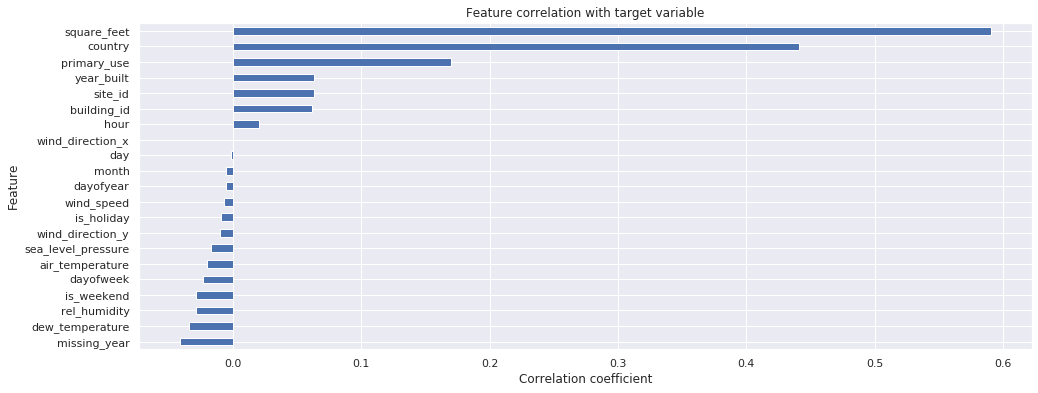

In [50]:
cor.meter_reading.sort_values()[:-1].plot.barh(figsize=(16, 6), title='Feature correlation with target variable')
plt.ylabel('Feature')
plt.xlabel('Correlation coefficient');

In [51]:
# Add features with a correlation coefficient of at least 0.1
cor_feats = cor[cor.meter_reading > 0.1].index[:-1].tolist()
feat_seln = udf.inc_feat_count(feat_seln, cor_feats)
feat_seln

,count
feature,
site_id,0
building_id,0
air_temperature,0
dew_temperature,0
sea_level_pressure,0
wind_speed,0
primary_use,2
square_feet,2
year_built,0


In [52]:
del e_train, cor
gc.collect()

4562

### Lasso regularization

In [53]:
# Select features using L1 regularization
l1_feats = udf.feats_from_model(Xe_train_scaled, ye_train, SelectFromModel, Lasso())
l1_feats

['building_id',
 'dew_temperature',
 'sea_level_pressure',
 'wind_speed',
 'primary_use',
 'square_feet',
 'year_built',
 'missing_year',
 'dayofyear',
 'hour',
 'dayofweek',
 'wind_direction_y',
 'is_weekend',
 'country',
 'is_holiday']

In [54]:
# Increase the regularization
l1_10_feats = udf.feats_from_model(Xe_train_scaled, ye_train, SelectFromModel, Lasso(alpha=10))
l1_10_feats

['primary_use', 'square_feet', 'is_weekend', 'country']

In [55]:
# Select features recursively using L1 regularization
rfe_l1_feats = udf.feats_from_model(Xe_train_scaled, ye_train.meter_reading.ravel(), RFE, Lasso())
rfe_l1_feats

['dew_temperature',
 'wind_speed',
 'primary_use',
 'square_feet',
 'year_built',
 'hour',
 'wind_direction_y',
 'is_weekend',
 'country',
 'is_holiday']

In [56]:
# Increment the counts of selected features
feat_seln = udf.inc_feat_count(feat_seln, l1_feats + l1_10_feats + rfe_l1_feats)
feat_seln

,count
feature,
site_id,0
building_id,1
air_temperature,0
dew_temperature,2
sea_level_pressure,1
wind_speed,2
primary_use,5
square_feet,5
year_built,2


In [57]:
gc.collect()

110

### Tree importance

In [58]:
# Select features using a decision tree
tree_feats = udf.feats_from_model(Xe_train_scaled, ye_train, SelectFromModel, DecisionTreeRegressor())
tree_feats

['building_id', 'square_feet', 'year_built', 'country']

In [59]:
# Select features recursively using a decision tree
rfe_tree_feats = udf.feats_from_model(Xe_train_scaled, ye_train.meter_reading.ravel(), RFE, DecisionTreeRegressor())
rfe_tree_feats

['building_id',
 'air_temperature',
 'dew_temperature',
 'primary_use',
 'square_feet',
 'year_built',
 'dayofyear',
 'hour',
 'dayofweek',
 'country']

In [60]:
# Increment the counts of selected features
feat_seln = udf.inc_feat_count(feat_seln, tree_feats + rfe_tree_feats)
feat_seln

,count
feature,
site_id,0
building_id,3
air_temperature,1
dew_temperature,3
sea_level_pressure,1
wind_speed,2
primary_use,6
square_feet,7
year_built,4


In [61]:
gc.collect()

88

### Boosting importance

In [62]:
# Select features using gradient boosting
boosting_feats = udf.feats_from_model(Xe_train_scaled, ye_train.meter_reading.ravel(), SelectFromModel, GradientBoostingRegressor())
boosting_feats

['building_id', 'primary_use', 'square_feet', 'year_built', 'country']

In [63]:
# Increment the counts of selected features
feat_seln = udf.inc_feat_count(feat_seln, boosting_feats)
feat_seln

,count
feature,
site_id,0
building_id,4
air_temperature,1
dew_temperature,3
sea_level_pressure,1
wind_speed,2
primary_use,7
square_feet,8
year_built,5


In [64]:
gc.collect()

66

### PCA

In [65]:
# PCA with 2 components
pca2 = PCA(n_components=2)
pca2.fit(Xe_train_scaled)
pca2.explained_variance_ratio_

array([0.12812145, 0.10483687])

In [66]:
# Principal components
pc2 = pd.DataFrame(pca2.components_, columns=Xe_train_scaled.columns).T
pc2.columns = ['PC1', 'PC2']
pc2

,PC1,PC2
site_id,0.434024,-0.376862
building_id,0.435920,-0.378465
air_temperature,-0.427383,-0.010134
dew_temperature,-0.384390,-0.211635
sea_level_pressure,0.052784,-0.163144
wind_speed,0.068884,0.183093
primary_use,-0.017791,0.074112
square_feet,0.044719,-0.039181
year_built,-0.083072,-0.004177
missing_year,0.236585,-0.231364


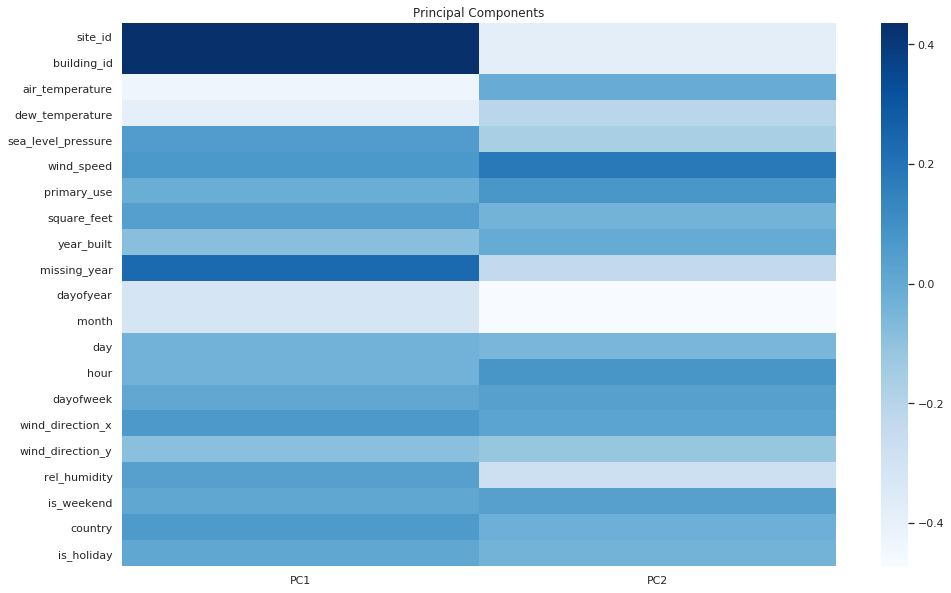

In [67]:
plt.figure(figsize=(16, 10))
sns.heatmap(pc2, cmap='Blues')
plt.title('Principal Components');

In [68]:
# PCA with 95% explained variance
pca95 = PCA(0.95)
pca95.fit(Xe_train_scaled)
pca95.explained_variance_ratio_

array([0.12812145, 0.10483689, 0.0864952 , 0.0805473 , 0.06836337,
       0.06215137, 0.06063641, 0.0507906 , 0.04767539, 0.04621581,
       0.04229265, 0.04145006, 0.03911197, 0.03708856, 0.03607625,
       0.02872784])

In [69]:
# Principal components
pc95 = pd.DataFrame(pca95.components_, columns=Xe_train_scaled.columns)
pc95

,site_id,building_id,air_temperature,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,...,month,day,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0.434034,0.435930,-0.427359,-0.384392,0.052816,0.068848,-0.017754,0.044729,-0.083102,0.236589,...,-0.314395,-0.034853,-0.033543,0.010104,0.065386,-0.088988,0.037654,0.012011,0.061483,0.010156
1,-0.376885,-0.378480,-0.010148,-0.211626,-0.163119,0.182985,0.073993,-0.039124,-0.004212,-0.231389,...,-0.470283,-0.051852,0.079319,0.035564,0.024362,-0.114713,-0.278561,0.036205,-0.022851,-0.037484
2,-0.047562,-0.045762,-0.063618,-0.068213,0.071542,-0.016833,0.015992,-0.005010,-0.007546,-0.045774,...,-0.006001,-0.015029,-0.015085,-0.689050,0.056109,0.002994,-0.006885,-0.682750,0.004208,0.185495
3,-0.209181,-0.195713,-0.437457,-0.394186,0.423298,-0.022098,0.125671,-0.014068,-0.061578,-0.287093,...,0.248048,0.022150,-0.129954,0.112776,0.308908,-0.069429,0.058171,0.117844,0.052039,0.123384
4,0.118389,0.097124,0.113064,-0.194247,-0.143945,0.407086,0.025608,0.104338,0.045767,0.055274,...,0.263071,0.027383,0.443767,-0.018144,0.093944,-0.375877,-0.473539,-0.019467,0.105646,0.005772
5,0.042286,0.057676,-0.002101,0.100185,-0.209102,-0.012452,0.529142,0.518149,-0.085573,-0.258918,...,-0.009313,-0.016059,-0.103091,-0.012992,-0.097972,-0.061785,0.173125,-0.017715,0.509868,-0.056658
6,-0.016939,-0.053585,0.108438,-0.150945,0.302194,-0.387612,-0.135276,0.358445,0.381378,0.168143,...,-0.061407,0.040969,0.125075,0.016848,0.013510,0.367291,-0.397444,0.021509,0.286198,0.010539
7,-0.010902,-0.031061,-0.093301,0.023145,-0.250330,0.195329,-0.375371,0.218936,0.639808,-0.073069,...,0.036195,-0.214068,-0.334198,-0.004343,0.217926,-0.199056,0.193511,-0.012876,0.013222,-0.035407
8,-0.008331,-0.014356,-0.073134,-0.040703,-0.054227,0.097433,-0.077888,0.059824,0.168524,-0.052049,...,-0.064222,0.918427,-0.101983,-0.006401,-0.221275,-0.076830,0.053860,0.013819,-0.033796,0.148941
9,0.008210,0.007198,-0.017830,0.028213,-0.016992,0.079347,0.003978,0.068243,0.080161,-0.042040,...,-0.011899,-0.233811,0.136626,0.074786,-0.292970,0.042967,0.069840,0.138602,-0.043726,0.886333


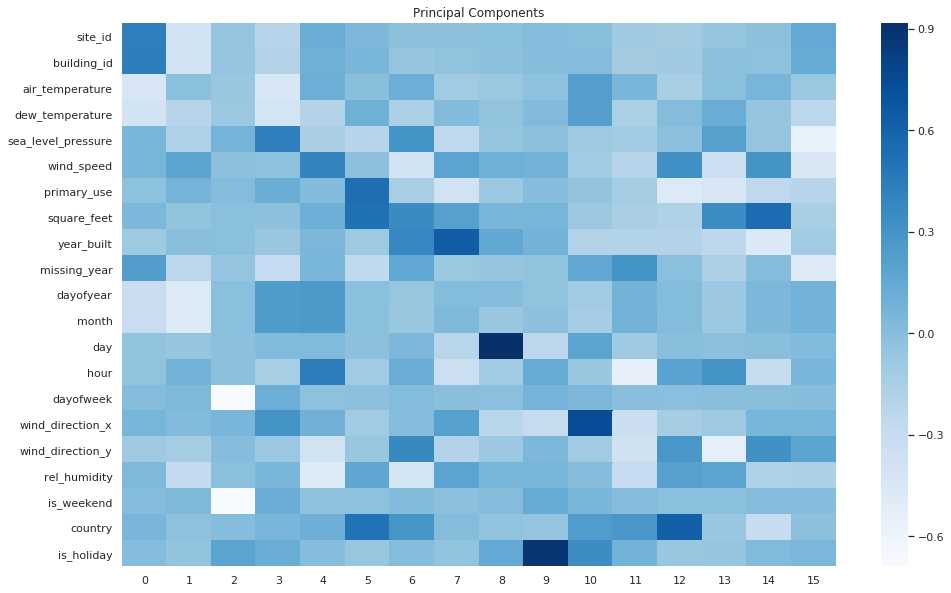

In [70]:
plt.figure(figsize=(16, 10))
sns.heatmap(pc95.T, cmap='Blues')
plt.title('Principal Components');

In [71]:
del pc2, pc95
gc.collect()

9746

### Remove features

In [72]:
# Drop month and day
Xe_train_scaled.drop(['month', 'day'], axis=1, inplace=True)
Xe_val_scaled.drop(['month', 'day'], axis=1, inplace=True)

Xe_train_scaled.head()

,site_id,building_id,air_temperature,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,dayofweek,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0.634687,0.751544,-0.663955,-0.997991,-0.472288,1.137662,-1.204465,-0.511722,0.072695,0.906510,-0.782138,0.071859,0.496847,1.351655,-0.664995,-0.816020,-0.633944,-0.044622,-0.180306
1,1.454185,1.249239,0.394554,-0.431526,-0.188800,0.448504,-0.172178,-0.581581,0.166086,0.906510,-0.744043,-0.505993,-1.005378,1.528077,-0.169618,-1.386566,-0.633944,-0.044622,-0.180306
2,-0.799436,-0.773568,-0.721172,-1.443071,1.633589,0.448504,-0.854998,-0.684758,-1.748416,-1.103132,-0.829756,0.216322,1.498330,-1.397300,0.357552,-1.349235,1.577426,-0.044622,-0.180306
3,-0.799436,-0.505010,0.394554,0.519327,0.202671,1.137662,-1.204465,-0.808842,-0.254171,0.906510,0.551170,-0.939382,0.496847,1.528077,0.357552,-0.009122,-0.633944,-0.044622,-0.180306
4,-0.799436,-0.657768,-0.978647,-1.443071,1.431102,0.663866,-0.898106,-0.567768,2.220673,-1.103132,1.322584,1.372026,-1.005378,1.203158,-0.881735,-1.026709,-0.633944,-0.044622,-0.180306


### Create dataframe of selected features for each method

In [73]:
# List of selected features and corresponding method name
sel = [l1_feats, l1_10_feats, rfe_l1_feats, tree_feats, rfe_tree_feats, boosting_feats]
col = ['lasso', 'lasso_alpha10', 'lasso_recursive', 'tree_importance', 'tree_importance_recursive', 'gradient_boosting']

# Selected features for each method
feats = pd.DataFrame(cor_feats, columns=['correlation'])
for i, s in enumerate(sel):
    feats = pd.merge(feats, pd.DataFrame(s, columns=[col[i]]), how='outer', left_index=True, right_index=True)
feats = feats.fillna('')
feats

,correlation,lasso,lasso_alpha10,lasso_recursive,tree_importance,tree_importance_recursive,gradient_boosting
0,primary_use,building_id,primary_use,dew_temperature,building_id,building_id,building_id
1,square_feet,dew_temperature,square_feet,wind_speed,square_feet,air_temperature,primary_use
2,country,sea_level_pressure,is_weekend,primary_use,year_built,dew_temperature,square_feet
3,,wind_speed,country,square_feet,country,primary_use,year_built
4,,primary_use,,year_built,,square_feet,country
5,,square_feet,,hour,,year_built,
6,,year_built,,wind_direction_y,,dayofyear,
7,,missing_year,,is_weekend,,hour,
8,,dayofyear,,country,,dayofweek,
9,,hour,,is_holiday,,country,


In [74]:
del sel, col, i, s
gc.collect()

22

### Save data

In [75]:
feats.to_csv(f'{path}feats.csv', index=False)
feats = pd.read_csv(f'{path}feats.csv')
feats

,correlation,lasso,lasso_alpha10,lasso_recursive,tree_importance,tree_importance_recursive,gradient_boosting
0,primary_use,building_id,primary_use,dew_temperature,building_id,building_id,building_id
1,square_feet,dew_temperature,square_feet,wind_speed,square_feet,air_temperature,primary_use
2,country,sea_level_pressure,is_weekend,primary_use,year_built,dew_temperature,square_feet
3,NaN,wind_speed,country,square_feet,country,primary_use,year_built
4,NaN,primary_use,NaN,year_built,NaN,square_feet,country
5,NaN,square_feet,NaN,hour,NaN,year_built,NaN
6,NaN,year_built,NaN,wind_direction_y,NaN,dayofyear,NaN
7,NaN,missing_year,NaN,is_weekend,NaN,hour,NaN
8,NaN,dayofyear,NaN,country,NaN,dayofweek,NaN
9,NaN,hour,NaN,is_holiday,NaN,country,NaN
